In [165]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

# Initialize the setting

In [166]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [167]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105  # zf: this is (joint_n * (joint_n-1)) / 2. the (flatten) diemsnion of JDC
        self.filters = 16
        self.data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose')
C = Config()
print(C.__dict__)
assert C.feat_d == C.joint_n*(C.joint_n-1) / 2, "feat_d should be the JCD dimension"

{'frame_l': 32, 'joint_n': 15, 'joint_d': 2, 'clc_num': 21, 'feat_d': 105, 'filters': 16, 'data_dir': '/home/ubuntu/zf/DD-Net/JHMDB/../data/JHMDB_openpose'}


In [168]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        # interploate to the right number of frames
        assert p.shape == (C.frame_l, C.joint_n, C.joint_d)

        label = np.zeros(C.clc_num)  # one-hot encoding
        label[le.transform(T['label'])[i]] = 1   # zf: why -1? it shifts all labels to the left by 1, though still valid

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [169]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [170]:
# helper functions for plotting
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Train and test on GT_split 1

In [177]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 98/98 [00:00<00:00, 373.25it/s]


In [178]:
Train['pose'][0].shape

(40, 15, 2)

### Data Dimensions and Examples

In [179]:
print([(k, type(v)) for k,v in Train.items()])
print(list(map(np.shape, Train['pose'][:5])))
print(len(Train['label']), Train['label'][0])
# the first dimension of each data point is the frame length, which is variable from the authors,
# which is why they use zoom() to rescale them to fixed frame length
# print(Train['pose'][0])

print(X_0.shape, X_1.shape, Y.shape)
print(le.classes_, len(le.classes_))
assert len(le.classes_) == 21
print(Train['label'][::10])

[('pose', <class 'list'>), ('label', <class 'list'>)]
[(40, 15, 2), (27, 15, 2), (40, 15, 2), (40, 15, 2), (40, 15, 2)]
272 push
(272, 32, 105) (272, 32, 15, 2) (272, 21)
['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave'] 21
['push', 'stand', 'run', 'shoot_ball', 'shoot_ball', 'clap', 'pullup', 'pullup', 'shoot_gun', 'shoot_gun', 'pick', 'shoot_bow', 'shoot_bow', 'throw', 'throw', 'climb_stairs', 'wave', 'golf', 'golf', 'catch', 'catch', 'catch', 'walk', 'swing_baseball', 'swing_baseball', 'pour', 'pour', 'pour']


In [180]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_19 (Model)                (None, 4, 128)       113056      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_10 (Global (None, 128)          0           model_19[1][0]            

In [181]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


Train on 272 samples, validate on 98 samples
Epoch 1/600
272/272 [==============================] - 9s 34ms/step - loss: 3.7076 - accuracy: 0.0404 - val_loss: 3.1748 - val_accuracy: 0.0306
Epoch 2/600
272/272 [==============================] - 0s 330us/step - loss: 3.6360 - accuracy: 0.0809 - val_loss: 3.1394 - val_accuracy: 0.0408
Epoch 3/600
272/272 [==============================] - 0s 319us/step - loss: 3.5210 - accuracy: 0.0699 - val_loss: 3.1263 - val_accuracy: 0.0204
Epoch 4/600
272/272 [==============================] - 0s 342us/step - loss: 3.3396 - accuracy: 0.0882 - val_loss: 3.1199 - val_accuracy: 0.0102
Epoch 5/600
272/272 [==============================] - 0s 317us/step - loss: 3.3632 - accuracy: 0.0735 - val_loss: 3.1142 - val_accuracy: 0.0204
Epoch 6/600
272/272 [==============================] - 0s 318us/step - loss: 3.4650 - accuracy: 0.1066 - val_loss: 3.1108 - val_accuracy: 0.0204
Epoch 7/600
272/272 [==============================] - 0s 314us/step - loss: 3.2534 - 

Epoch 57/600
272/272 [==============================] - 0s 286us/step - loss: 2.2408 - accuracy: 0.3309 - val_loss: 2.7002 - val_accuracy: 0.2551
Epoch 58/600
272/272 [==============================] - 0s 286us/step - loss: 2.2115 - accuracy: 0.3382 - val_loss: 2.6954 - val_accuracy: 0.2551
Epoch 59/600
272/272 [==============================] - 0s 292us/step - loss: 2.3314 - accuracy: 0.3382 - val_loss: 2.6904 - val_accuracy: 0.2653
Epoch 60/600
272/272 [==============================] - 0s 293us/step - loss: 2.2623 - accuracy: 0.3235 - val_loss: 2.6853 - val_accuracy: 0.2653
Epoch 61/600
272/272 [==============================] - 0s 295us/step - loss: 2.1550 - accuracy: 0.3346 - val_loss: 2.6805 - val_accuracy: 0.2653
Epoch 62/600
272/272 [==============================] - 0s 286us/step - loss: 2.1378 - accuracy: 0.3235 - val_loss: 2.6758 - val_accuracy: 0.2653
Epoch 63/600
272/272 [==============================] - 0s 293us/step - loss: 2.1311 - accuracy: 0.3382 - val_loss: 2.6711 -

272/272 [==============================] - 0s 287us/step - loss: 1.9442 - accuracy: 0.4449 - val_loss: 2.4965 - val_accuracy: 0.2755
Epoch 114/600
272/272 [==============================] - 0s 284us/step - loss: 1.9781 - accuracy: 0.3971 - val_loss: 2.4939 - val_accuracy: 0.2755
Epoch 115/600
272/272 [==============================] - 0s 286us/step - loss: 1.9495 - accuracy: 0.3971 - val_loss: 2.4913 - val_accuracy: 0.2755
Epoch 116/600
272/272 [==============================] - 0s 286us/step - loss: 1.8775 - accuracy: 0.4118 - val_loss: 2.4892 - val_accuracy: 0.2755
Epoch 117/600
272/272 [==============================] - 0s 285us/step - loss: 1.8367 - accuracy: 0.4412 - val_loss: 2.4871 - val_accuracy: 0.2755
Epoch 118/600
272/272 [==============================] - 0s 284us/step - loss: 1.9757 - accuracy: 0.3713 - val_loss: 2.4852 - val_accuracy: 0.2755
Epoch 119/600
272/272 [==============================] - 0s 286us/step - loss: 1.8448 - accuracy: 0.4081 - val_loss: 2.4833 - val_ac

Epoch 169/600
272/272 [==============================] - 0s 273us/step - loss: 1.9057 - accuracy: 0.4191 - val_loss: 2.4307 - val_accuracy: 0.2755
Epoch 170/600
272/272 [==============================] - 0s 281us/step - loss: 1.9309 - accuracy: 0.4301 - val_loss: 2.4302 - val_accuracy: 0.2755
Epoch 171/600
272/272 [==============================] - 0s 265us/step - loss: 1.9131 - accuracy: 0.4154 - val_loss: 2.4298 - val_accuracy: 0.2755
Epoch 172/600
272/272 [==============================] - 0s 266us/step - loss: 1.8914 - accuracy: 0.4265 - val_loss: 2.4292 - val_accuracy: 0.2653
Epoch 173/600
272/272 [==============================] - 0s 269us/step - loss: 1.9486 - accuracy: 0.3971 - val_loss: 2.4288 - val_accuracy: 0.2653
Epoch 174/600
272/272 [==============================] - 0s 272us/step - loss: 1.9202 - accuracy: 0.4007 - val_loss: 2.4284 - val_accuracy: 0.2653
Epoch 175/600
272/272 [==============================] - 0s 292us/step - loss: 2.0083 - accuracy: 0.3640 - val_loss: 2

Epoch 225/600
272/272 [==============================] - 0s 271us/step - loss: 1.9385 - accuracy: 0.4154 - val_loss: 2.4176 - val_accuracy: 0.2653
Epoch 226/600
272/272 [==============================] - 0s 273us/step - loss: 1.8717 - accuracy: 0.3934 - val_loss: 2.4176 - val_accuracy: 0.2653
Epoch 227/600
272/272 [==============================] - 0s 272us/step - loss: 1.9632 - accuracy: 0.3713 - val_loss: 2.4175 - val_accuracy: 0.2653
Epoch 228/600
272/272 [==============================] - 0s 271us/step - loss: 1.9244 - accuracy: 0.4118 - val_loss: 2.4174 - val_accuracy: 0.2653
Epoch 229/600
272/272 [==============================] - 0s 267us/step - loss: 1.8021 - accuracy: 0.4228 - val_loss: 2.4173 - val_accuracy: 0.2653
Epoch 230/600
272/272 [==============================] - 0s 277us/step - loss: 1.8683 - accuracy: 0.4044 - val_loss: 2.4173 - val_accuracy: 0.2653
Epoch 231/600
272/272 [==============================] - 0s 273us/step - loss: 1.8767 - accuracy: 0.4338 - val_loss: 2

Epoch 281/600
272/272 [==============================] - 0s 269us/step - loss: 1.9391 - accuracy: 0.4118 - val_loss: 2.4205 - val_accuracy: 0.2653
Epoch 282/600
272/272 [==============================] - 0s 270us/step - loss: 1.9509 - accuracy: 0.4044 - val_loss: 2.4206 - val_accuracy: 0.2653
Epoch 283/600
272/272 [==============================] - 0s 271us/step - loss: 1.8784 - accuracy: 0.4338 - val_loss: 2.4207 - val_accuracy: 0.2653
Epoch 284/600
272/272 [==============================] - 0s 271us/step - loss: 1.9339 - accuracy: 0.4375 - val_loss: 2.4209 - val_accuracy: 0.2653
Epoch 285/600
272/272 [==============================] - 0s 273us/step - loss: 1.8973 - accuracy: 0.4118 - val_loss: 2.4208 - val_accuracy: 0.2653
Epoch 286/600
272/272 [==============================] - 0s 271us/step - loss: 1.9202 - accuracy: 0.3971 - val_loss: 2.4210 - val_accuracy: 0.2653
Epoch 287/600
272/272 [==============================] - 0s 270us/step - loss: 1.9275 - accuracy: 0.4375 - val_loss: 2

Epoch 337/600
272/272 [==============================] - 0s 268us/step - loss: 1.8651 - accuracy: 0.4412 - val_loss: 2.4280 - val_accuracy: 0.2551
Epoch 338/600
272/272 [==============================] - 0s 279us/step - loss: 1.8603 - accuracy: 0.4449 - val_loss: 2.4283 - val_accuracy: 0.2551
Epoch 339/600
272/272 [==============================] - 0s 273us/step - loss: 1.9060 - accuracy: 0.4449 - val_loss: 2.4285 - val_accuracy: 0.2551
Epoch 340/600
272/272 [==============================] - 0s 268us/step - loss: 1.9199 - accuracy: 0.4007 - val_loss: 2.4286 - val_accuracy: 0.2551
Epoch 341/600
272/272 [==============================] - 0s 269us/step - loss: 1.8370 - accuracy: 0.4522 - val_loss: 2.4287 - val_accuracy: 0.2551
Epoch 342/600
272/272 [==============================] - 0s 276us/step - loss: 1.8723 - accuracy: 0.4228 - val_loss: 2.4287 - val_accuracy: 0.2551
Epoch 343/600
272/272 [==============================] - 0s 278us/step - loss: 1.8671 - accuracy: 0.4485 - val_loss: 2

Epoch 393/600
272/272 [==============================] - 0s 264us/step - loss: 1.8479 - accuracy: 0.4375 - val_loss: 2.4347 - val_accuracy: 0.2551
Epoch 394/600
272/272 [==============================] - 0s 270us/step - loss: 1.9074 - accuracy: 0.4154 - val_loss: 2.4348 - val_accuracy: 0.2551
Epoch 395/600
272/272 [==============================] - 0s 260us/step - loss: 1.9141 - accuracy: 0.4265 - val_loss: 2.4347 - val_accuracy: 0.2551
Epoch 396/600
272/272 [==============================] - 0s 264us/step - loss: 1.8452 - accuracy: 0.4338 - val_loss: 2.4348 - val_accuracy: 0.2551
Epoch 397/600
272/272 [==============================] - 0s 263us/step - loss: 1.9744 - accuracy: 0.4154 - val_loss: 2.4351 - val_accuracy: 0.2551
Epoch 398/600
272/272 [==============================] - 0s 265us/step - loss: 1.8236 - accuracy: 0.4338 - val_loss: 2.4353 - val_accuracy: 0.2551
Epoch 399/600
272/272 [==============================] - 0s 266us/step - loss: 1.8058 - accuracy: 0.4632 - val_loss: 2

Epoch 449/600
272/272 [==============================] - 0s 279us/step - loss: 1.7971 - accuracy: 0.4449 - val_loss: 2.4375 - val_accuracy: 0.2551
Epoch 450/600
272/272 [==============================] - 0s 289us/step - loss: 1.8053 - accuracy: 0.3897 - val_loss: 2.4373 - val_accuracy: 0.2551
Epoch 451/600
272/272 [==============================] - 0s 267us/step - loss: 1.9362 - accuracy: 0.3971 - val_loss: 2.4376 - val_accuracy: 0.2551
Epoch 452/600
272/272 [==============================] - 0s 288us/step - loss: 1.8800 - accuracy: 0.4228 - val_loss: 2.4375 - val_accuracy: 0.2551
Epoch 453/600
272/272 [==============================] - 0s 280us/step - loss: 1.8524 - accuracy: 0.4228 - val_loss: 2.4376 - val_accuracy: 0.2551
Epoch 454/600
272/272 [==============================] - 0s 271us/step - loss: 1.8175 - accuracy: 0.4375 - val_loss: 2.4373 - val_accuracy: 0.2551
Epoch 455/600
272/272 [==============================] - 0s 284us/step - loss: 1.8494 - accuracy: 0.4118 - val_loss: 2

Epoch 505/600
272/272 [==============================] - 0s 265us/step - loss: 1.8329 - accuracy: 0.4375 - val_loss: 2.4356 - val_accuracy: 0.2449
Epoch 506/600
272/272 [==============================] - 0s 275us/step - loss: 1.7373 - accuracy: 0.4743 - val_loss: 2.4357 - val_accuracy: 0.2449
Epoch 507/600
272/272 [==============================] - 0s 273us/step - loss: 1.8712 - accuracy: 0.4375 - val_loss: 2.4355 - val_accuracy: 0.2449
Epoch 508/600
272/272 [==============================] - 0s 271us/step - loss: 1.9059 - accuracy: 0.3676 - val_loss: 2.4357 - val_accuracy: 0.2449
Epoch 509/600
272/272 [==============================] - 0s 275us/step - loss: 1.8366 - accuracy: 0.4485 - val_loss: 2.4357 - val_accuracy: 0.2449
Epoch 510/600
272/272 [==============================] - 0s 264us/step - loss: 1.8703 - accuracy: 0.4118 - val_loss: 2.4357 - val_accuracy: 0.2449
Epoch 511/600
272/272 [==============================] - 0s 268us/step - loss: 1.8566 - accuracy: 0.4044 - val_loss: 2

Epoch 561/600
272/272 [==============================] - 0s 268us/step - loss: 1.8837 - accuracy: 0.4154 - val_loss: 2.4335 - val_accuracy: 0.2449
Epoch 562/600
272/272 [==============================] - 0s 266us/step - loss: 1.7835 - accuracy: 0.4743 - val_loss: 2.4336 - val_accuracy: 0.2449
Epoch 563/600
272/272 [==============================] - 0s 275us/step - loss: 1.8154 - accuracy: 0.4338 - val_loss: 2.4339 - val_accuracy: 0.2449
Epoch 564/600
272/272 [==============================] - 0s 269us/step - loss: 1.8639 - accuracy: 0.4265 - val_loss: 2.4341 - val_accuracy: 0.2449
Epoch 565/600
272/272 [==============================] - 0s 278us/step - loss: 1.8257 - accuracy: 0.4522 - val_loss: 2.4341 - val_accuracy: 0.2449
Epoch 566/600
272/272 [==============================] - 0s 274us/step - loss: 1.8744 - accuracy: 0.4081 - val_loss: 2.4343 - val_accuracy: 0.2449
Epoch 567/600
272/272 [==============================] - 0s 272us/step - loss: 1.8555 - accuracy: 0.4228 - val_loss: 2

Epoch 17/500
272/272 [==============================] - 0s 311us/step - loss: 1.8322 - accuracy: 0.4154 - val_loss: 2.4269 - val_accuracy: 0.2551
Epoch 18/500
272/272 [==============================] - 0s 312us/step - loss: 1.7674 - accuracy: 0.4522 - val_loss: 2.4264 - val_accuracy: 0.2551
Epoch 19/500
272/272 [==============================] - 0s 302us/step - loss: 1.9041 - accuracy: 0.4632 - val_loss: 2.4265 - val_accuracy: 0.2551
Epoch 20/500
272/272 [==============================] - 0s 316us/step - loss: 1.7851 - accuracy: 0.4375 - val_loss: 2.4264 - val_accuracy: 0.2551
Epoch 21/500
272/272 [==============================] - 0s 324us/step - loss: 1.8321 - accuracy: 0.4081 - val_loss: 2.4263 - val_accuracy: 0.2551
Epoch 22/500
272/272 [==============================] - 0s 321us/step - loss: 1.7729 - accuracy: 0.4485 - val_loss: 2.4264 - val_accuracy: 0.2551
Epoch 23/500
272/272 [==============================] - 0s 302us/step - loss: 1.7560 - accuracy: 0.4632 - val_loss: 2.4265 -

Epoch 74/500
272/272 [==============================] - 0s 283us/step - loss: 1.7095 - accuracy: 0.4890 - val_loss: 2.4249 - val_accuracy: 0.2551
Epoch 75/500
272/272 [==============================] - 0s 289us/step - loss: 1.8691 - accuracy: 0.4669 - val_loss: 2.4248 - val_accuracy: 0.2551
Epoch 76/500
272/272 [==============================] - 0s 293us/step - loss: 1.7535 - accuracy: 0.4853 - val_loss: 2.4248 - val_accuracy: 0.2551
Epoch 77/500
272/272 [==============================] - 0s 285us/step - loss: 1.8191 - accuracy: 0.4449 - val_loss: 2.4249 - val_accuracy: 0.2551
Epoch 78/500
272/272 [==============================] - 0s 293us/step - loss: 1.7490 - accuracy: 0.4632 - val_loss: 2.4248 - val_accuracy: 0.2551
Epoch 79/500
272/272 [==============================] - 0s 281us/step - loss: 1.6515 - accuracy: 0.4706 - val_loss: 2.4248 - val_accuracy: 0.2551
Epoch 80/500
272/272 [==============================] - 0s 283us/step - loss: 1.8539 - accuracy: 0.4596 - val_loss: 2.4250 -

Epoch 130/500
272/272 [==============================] - 0s 266us/step - loss: 1.8015 - accuracy: 0.4412 - val_loss: 2.4231 - val_accuracy: 0.2551
Epoch 131/500
272/272 [==============================] - 0s 268us/step - loss: 1.8375 - accuracy: 0.4706 - val_loss: 2.4231 - val_accuracy: 0.2551
Epoch 132/500
272/272 [==============================] - 0s 276us/step - loss: 1.8260 - accuracy: 0.4522 - val_loss: 2.4231 - val_accuracy: 0.2551
Epoch 133/500
272/272 [==============================] - 0s 267us/step - loss: 1.7291 - accuracy: 0.4669 - val_loss: 2.4232 - val_accuracy: 0.2551
Epoch 134/500
272/272 [==============================] - 0s 272us/step - loss: 1.7454 - accuracy: 0.4816 - val_loss: 2.4232 - val_accuracy: 0.2551
Epoch 135/500
272/272 [==============================] - 0s 276us/step - loss: 1.7613 - accuracy: 0.4559 - val_loss: 2.4232 - val_accuracy: 0.2551
Epoch 136/500
272/272 [==============================] - 0s 274us/step - loss: 1.7971 - accuracy: 0.4596 - val_loss: 2

Epoch 186/500
272/272 [==============================] - 0s 277us/step - loss: 1.8219 - accuracy: 0.4559 - val_loss: 2.4213 - val_accuracy: 0.2551
Epoch 187/500
272/272 [==============================] - 0s 274us/step - loss: 1.7798 - accuracy: 0.4632 - val_loss: 2.4212 - val_accuracy: 0.2551
Epoch 188/500
272/272 [==============================] - 0s 276us/step - loss: 1.7756 - accuracy: 0.4926 - val_loss: 2.4212 - val_accuracy: 0.2551
Epoch 189/500
272/272 [==============================] - 0s 268us/step - loss: 1.7727 - accuracy: 0.4853 - val_loss: 2.4211 - val_accuracy: 0.2551
Epoch 190/500
272/272 [==============================] - 0s 271us/step - loss: 1.8543 - accuracy: 0.4301 - val_loss: 2.4210 - val_accuracy: 0.2551
Epoch 191/500
272/272 [==============================] - 0s 268us/step - loss: 1.7829 - accuracy: 0.4963 - val_loss: 2.4208 - val_accuracy: 0.2551
Epoch 192/500
272/272 [==============================] - 0s 274us/step - loss: 1.7756 - accuracy: 0.4301 - val_loss: 2

Epoch 242/500
272/272 [==============================] - 0s 270us/step - loss: 1.7524 - accuracy: 0.4632 - val_loss: 2.4202 - val_accuracy: 0.2551
Epoch 243/500
272/272 [==============================] - 0s 270us/step - loss: 1.8404 - accuracy: 0.4485 - val_loss: 2.4202 - val_accuracy: 0.2551
Epoch 244/500
272/272 [==============================] - 0s 281us/step - loss: 1.7515 - accuracy: 0.4375 - val_loss: 2.4203 - val_accuracy: 0.2551
Epoch 245/500
272/272 [==============================] - 0s 270us/step - loss: 1.8767 - accuracy: 0.4081 - val_loss: 2.4204 - val_accuracy: 0.2551
Epoch 246/500
272/272 [==============================] - 0s 275us/step - loss: 1.8423 - accuracy: 0.4412 - val_loss: 2.4203 - val_accuracy: 0.2551
Epoch 247/500
272/272 [==============================] - 0s 271us/step - loss: 1.7391 - accuracy: 0.4522 - val_loss: 2.4203 - val_accuracy: 0.2551
Epoch 248/500
272/272 [==============================] - 0s 275us/step - loss: 1.7691 - accuracy: 0.5000 - val_loss: 2

Epoch 298/500
272/272 [==============================] - 0s 276us/step - loss: 1.7280 - accuracy: 0.4706 - val_loss: 2.4174 - val_accuracy: 0.2551
Epoch 299/500
272/272 [==============================] - 0s 270us/step - loss: 1.7364 - accuracy: 0.4485 - val_loss: 2.4174 - val_accuracy: 0.2551
Epoch 300/500
272/272 [==============================] - 0s 275us/step - loss: 1.7877 - accuracy: 0.4853 - val_loss: 2.4175 - val_accuracy: 0.2551
Epoch 301/500
272/272 [==============================] - 0s 270us/step - loss: 1.7883 - accuracy: 0.4301 - val_loss: 2.4176 - val_accuracy: 0.2551
Epoch 302/500
272/272 [==============================] - 0s 269us/step - loss: 1.7949 - accuracy: 0.4706 - val_loss: 2.4178 - val_accuracy: 0.2551
Epoch 303/500
272/272 [==============================] - 0s 281us/step - loss: 1.8502 - accuracy: 0.4743 - val_loss: 2.4177 - val_accuracy: 0.2551
Epoch 304/500
272/272 [==============================] - 0s 274us/step - loss: 1.7594 - accuracy: 0.4632 - val_loss: 2

Epoch 354/500
272/272 [==============================] - 0s 269us/step - loss: 1.7941 - accuracy: 0.4816 - val_loss: 2.4175 - val_accuracy: 0.2551
Epoch 355/500
272/272 [==============================] - 0s 277us/step - loss: 1.7934 - accuracy: 0.4706 - val_loss: 2.4176 - val_accuracy: 0.2551
Epoch 356/500
272/272 [==============================] - 0s 275us/step - loss: 1.6997 - accuracy: 0.4706 - val_loss: 2.4175 - val_accuracy: 0.2551
Epoch 357/500
272/272 [==============================] - 0s 272us/step - loss: 1.7008 - accuracy: 0.4743 - val_loss: 2.4176 - val_accuracy: 0.2551
Epoch 358/500
272/272 [==============================] - 0s 273us/step - loss: 1.6903 - accuracy: 0.4669 - val_loss: 2.4178 - val_accuracy: 0.2551
Epoch 359/500
272/272 [==============================] - 0s 273us/step - loss: 1.8309 - accuracy: 0.4596 - val_loss: 2.4178 - val_accuracy: 0.2551
Epoch 360/500
272/272 [==============================] - 0s 273us/step - loss: 1.6986 - accuracy: 0.4963 - val_loss: 2

Epoch 410/500
272/272 [==============================] - 0s 271us/step - loss: 1.7901 - accuracy: 0.4449 - val_loss: 2.4167 - val_accuracy: 0.2551
Epoch 411/500
272/272 [==============================] - 0s 279us/step - loss: 1.7339 - accuracy: 0.4890 - val_loss: 2.4167 - val_accuracy: 0.2551
Epoch 412/500
272/272 [==============================] - 0s 273us/step - loss: 1.7206 - accuracy: 0.4779 - val_loss: 2.4165 - val_accuracy: 0.2551
Epoch 413/500
272/272 [==============================] - 0s 274us/step - loss: 1.8663 - accuracy: 0.4118 - val_loss: 2.4167 - val_accuracy: 0.2551
Epoch 414/500
272/272 [==============================] - 0s 269us/step - loss: 1.7453 - accuracy: 0.4669 - val_loss: 2.4165 - val_accuracy: 0.2551
Epoch 415/500
272/272 [==============================] - 0s 272us/step - loss: 1.7409 - accuracy: 0.4963 - val_loss: 2.4165 - val_accuracy: 0.2551
Epoch 416/500
272/272 [==============================] - 0s 274us/step - loss: 1.8190 - accuracy: 0.4522 - val_loss: 2

Epoch 466/500
272/272 [==============================] - 0s 290us/step - loss: 1.7298 - accuracy: 0.4596 - val_loss: 2.4163 - val_accuracy: 0.2551
Epoch 467/500
272/272 [==============================] - 0s 283us/step - loss: 1.6798 - accuracy: 0.4816 - val_loss: 2.4162 - val_accuracy: 0.2551
Epoch 468/500
272/272 [==============================] - 0s 286us/step - loss: 1.7051 - accuracy: 0.4669 - val_loss: 2.4161 - val_accuracy: 0.2551
Epoch 469/500
272/272 [==============================] - 0s 283us/step - loss: 1.7945 - accuracy: 0.4559 - val_loss: 2.4160 - val_accuracy: 0.2551
Epoch 470/500
272/272 [==============================] - 0s 287us/step - loss: 1.6893 - accuracy: 0.4632 - val_loss: 2.4161 - val_accuracy: 0.2551
Epoch 471/500
272/272 [==============================] - 0s 280us/step - loss: 1.7447 - accuracy: 0.4890 - val_loss: 2.4161 - val_accuracy: 0.2551
Epoch 472/500
272/272 [==============================] - 0s 283us/step - loss: 1.7424 - accuracy: 0.4926 - val_loss: 2

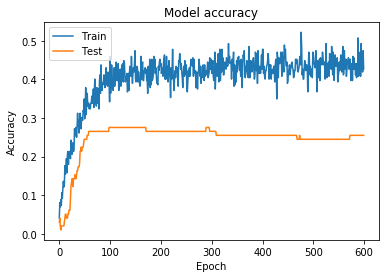

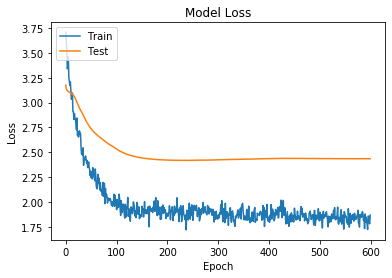

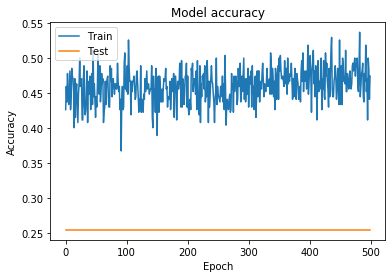

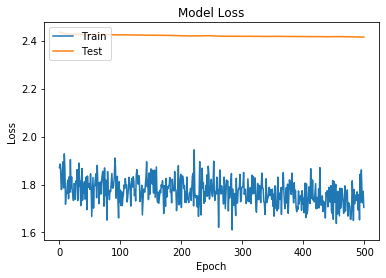

In [182]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Train and test on GT_split 2

In [12]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_2.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_2.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 270/270 [00:00<00:00, 325.46it/s]


In [13]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [14]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 658 samples, validate on 270 samples
Epoch 1/600
658/658 [==============================] - 3s 5ms/step - loss: 3.7625 - accuracy: 0.0456 - val_loss: 3.0440 - val_accuracy: 0.0815
Epoch 2/600
658/658 [==============================] - 0s 164us/step - loss: 3.6083 - accuracy: 0.0623 - val_loss: 3.0431 - val_accuracy: 0.0667
Epoch 3/600
658/658 [==============================] - 0s 153us/step - loss: 3.4016 - accuracy: 0.0745 - val_loss: 3.0412 - val_accuracy: 0.0889
Epoch 4/600
658/658 [==============================] - 0s 136us/step - loss: 3.3082 - accuracy: 0.0775 - val_loss: 3.0390 - val_accuracy: 0.0926
Epoch 5/600
658/658 [==============================] - 0s 136us/step - loss: 3.2278 - accuracy: 0.0957 - val_loss: 3.0370 - val_accuracy: 0.0704
Epoch 6/600
658/658 [==============================] - 0s 143us/step - loss: 3.2187 - accuracy: 0.0942 - val_loss: 3.0359 - val_accuracy: 0.0519
Epoch 7/600
658/658 [==============================] - 0s 140us/step - loss: 3.0378 - 

Epoch 57/600
658/658 [==============================] - 0s 137us/step - loss: 1.6210 - accuracy: 0.4742 - val_loss: 2.9114 - val_accuracy: 0.1963
Epoch 58/600
658/658 [==============================] - 0s 140us/step - loss: 1.5805 - accuracy: 0.5015 - val_loss: 2.9079 - val_accuracy: 0.1963
Epoch 59/600
658/658 [==============================] - 0s 140us/step - loss: 1.5764 - accuracy: 0.5000 - val_loss: 2.9024 - val_accuracy: 0.1963
Epoch 60/600
658/658 [==============================] - 0s 138us/step - loss: 1.5734 - accuracy: 0.5046 - val_loss: 2.8971 - val_accuracy: 0.2037
Epoch 61/600
658/658 [==============================] - 0s 143us/step - loss: 1.5950 - accuracy: 0.4696 - val_loss: 2.8925 - val_accuracy: 0.2000
Epoch 62/600
658/658 [==============================] - 0s 130us/step - loss: 1.5526 - accuracy: 0.4954 - val_loss: 2.8924 - val_accuracy: 0.2074
Epoch 63/600
658/658 [==============================] - 0s 130us/step - loss: 1.5634 - accuracy: 0.5152 - val_loss: 2.8935 -

658/658 [==============================] - 0s 139us/step - loss: 1.3713 - accuracy: 0.5684 - val_loss: 2.9859 - val_accuracy: 0.1778
Epoch 114/600
658/658 [==============================] - 0s 134us/step - loss: 1.3522 - accuracy: 0.5760 - val_loss: 2.9869 - val_accuracy: 0.1778
Epoch 115/600
658/658 [==============================] - 0s 134us/step - loss: 1.4103 - accuracy: 0.5243 - val_loss: 2.9888 - val_accuracy: 0.1815
Epoch 116/600
658/658 [==============================] - 0s 136us/step - loss: 1.3584 - accuracy: 0.5836 - val_loss: 2.9898 - val_accuracy: 0.1815
Epoch 117/600
658/658 [==============================] - 0s 129us/step - loss: 1.4126 - accuracy: 0.5456 - val_loss: 2.9912 - val_accuracy: 0.1815
Epoch 118/600
658/658 [==============================] - 0s 130us/step - loss: 1.3627 - accuracy: 0.5532 - val_loss: 2.9927 - val_accuracy: 0.1815
Epoch 119/600
658/658 [==============================] - 0s 136us/step - loss: 1.3893 - accuracy: 0.5441 - val_loss: 2.9944 - val_ac

Epoch 169/600
658/658 [==============================] - 0s 125us/step - loss: 1.3659 - accuracy: 0.5593 - val_loss: 2.9688 - val_accuracy: 0.2074
Epoch 170/600
658/658 [==============================] - 0s 129us/step - loss: 1.3930 - accuracy: 0.5638 - val_loss: 2.9671 - val_accuracy: 0.2074
Epoch 171/600
658/658 [==============================] - 0s 126us/step - loss: 1.3717 - accuracy: 0.5684 - val_loss: 2.9650 - val_accuracy: 0.2111
Epoch 172/600
658/658 [==============================] - 0s 127us/step - loss: 1.3450 - accuracy: 0.5669 - val_loss: 2.9631 - val_accuracy: 0.2111
Epoch 173/600
658/658 [==============================] - 0s 129us/step - loss: 1.3910 - accuracy: 0.5456 - val_loss: 2.9616 - val_accuracy: 0.2111
Epoch 174/600
658/658 [==============================] - 0s 128us/step - loss: 1.4259 - accuracy: 0.5502 - val_loss: 2.9595 - val_accuracy: 0.2111
Epoch 175/600
658/658 [==============================] - 0s 125us/step - loss: 1.3428 - accuracy: 0.5578 - val_loss: 2

Epoch 225/600
658/658 [==============================] - 0s 138us/step - loss: 1.3925 - accuracy: 0.5426 - val_loss: 2.8230 - val_accuracy: 0.2593
Epoch 226/600
658/658 [==============================] - 0s 132us/step - loss: 1.3455 - accuracy: 0.5745 - val_loss: 2.8198 - val_accuracy: 0.2593
Epoch 227/600
658/658 [==============================] - 0s 132us/step - loss: 1.4006 - accuracy: 0.5517 - val_loss: 2.8167 - val_accuracy: 0.2593
Epoch 228/600
658/658 [==============================] - 0s 132us/step - loss: 1.3869 - accuracy: 0.5456 - val_loss: 2.8131 - val_accuracy: 0.2593
Epoch 229/600
658/658 [==============================] - 0s 139us/step - loss: 1.3285 - accuracy: 0.5821 - val_loss: 2.8096 - val_accuracy: 0.2630
Epoch 230/600
658/658 [==============================] - 0s 129us/step - loss: 1.3372 - accuracy: 0.5729 - val_loss: 2.8063 - val_accuracy: 0.2630
Epoch 231/600
658/658 [==============================] - 0s 130us/step - loss: 1.3836 - accuracy: 0.5745 - val_loss: 2

Epoch 281/600
658/658 [==============================] - 0s 131us/step - loss: 1.3509 - accuracy: 0.5851 - val_loss: 2.6380 - val_accuracy: 0.3074
Epoch 282/600
658/658 [==============================] - 0s 127us/step - loss: 1.4048 - accuracy: 0.5471 - val_loss: 2.6348 - val_accuracy: 0.3074
Epoch 283/600
658/658 [==============================] - 0s 131us/step - loss: 1.4220 - accuracy: 0.5547 - val_loss: 2.6314 - val_accuracy: 0.3111
Epoch 284/600
658/658 [==============================] - 0s 124us/step - loss: 1.4180 - accuracy: 0.5426 - val_loss: 2.6281 - val_accuracy: 0.3111
Epoch 285/600
658/658 [==============================] - 0s 126us/step - loss: 1.3659 - accuracy: 0.5486 - val_loss: 2.6246 - val_accuracy: 0.3111
Epoch 286/600
658/658 [==============================] - 0s 131us/step - loss: 1.3103 - accuracy: 0.5973 - val_loss: 2.6210 - val_accuracy: 0.3074
Epoch 287/600
658/658 [==============================] - 0s 127us/step - loss: 1.3283 - accuracy: 0.5927 - val_loss: 2

Epoch 337/600
658/658 [==============================] - 0s 128us/step - loss: 1.3313 - accuracy: 0.5669 - val_loss: 2.4441 - val_accuracy: 0.3519
Epoch 338/600
658/658 [==============================] - 0s 128us/step - loss: 1.3589 - accuracy: 0.5623 - val_loss: 2.4408 - val_accuracy: 0.3519
Epoch 339/600
658/658 [==============================] - 0s 125us/step - loss: 1.3336 - accuracy: 0.5775 - val_loss: 2.4377 - val_accuracy: 0.3519
Epoch 340/600
658/658 [==============================] - 0s 129us/step - loss: 1.3540 - accuracy: 0.5486 - val_loss: 2.4340 - val_accuracy: 0.3519
Epoch 341/600
658/658 [==============================] - 0s 131us/step - loss: 1.3684 - accuracy: 0.5714 - val_loss: 2.4310 - val_accuracy: 0.3519
Epoch 342/600
658/658 [==============================] - 0s 129us/step - loss: 1.3718 - accuracy: 0.5897 - val_loss: 2.4275 - val_accuracy: 0.3556
Epoch 343/600
658/658 [==============================] - 0s 126us/step - loss: 1.3952 - accuracy: 0.5289 - val_loss: 2

Epoch 393/600
658/658 [==============================] - 0s 134us/step - loss: 1.3736 - accuracy: 0.5836 - val_loss: 2.2352 - val_accuracy: 0.3815
Epoch 394/600
658/658 [==============================] - 0s 128us/step - loss: 1.3422 - accuracy: 0.5760 - val_loss: 2.2315 - val_accuracy: 0.3852
Epoch 395/600
658/658 [==============================] - 0s 125us/step - loss: 1.3666 - accuracy: 0.5745 - val_loss: 2.2275 - val_accuracy: 0.3852
Epoch 396/600
658/658 [==============================] - 0s 137us/step - loss: 1.3407 - accuracy: 0.5669 - val_loss: 2.2234 - val_accuracy: 0.3889
Epoch 397/600
658/658 [==============================] - 0s 128us/step - loss: 1.3220 - accuracy: 0.5593 - val_loss: 2.2198 - val_accuracy: 0.3926
Epoch 398/600
658/658 [==============================] - 0s 129us/step - loss: 1.3795 - accuracy: 0.5441 - val_loss: 2.2157 - val_accuracy: 0.3926
Epoch 399/600
658/658 [==============================] - 0s 132us/step - loss: 1.3231 - accuracy: 0.5745 - val_loss: 2

Epoch 449/600
658/658 [==============================] - 0s 130us/step - loss: 1.3469 - accuracy: 0.5760 - val_loss: 2.0141 - val_accuracy: 0.4148
Epoch 450/600
658/658 [==============================] - 0s 125us/step - loss: 1.3193 - accuracy: 0.5638 - val_loss: 2.0102 - val_accuracy: 0.4185
Epoch 451/600
658/658 [==============================] - 0s 127us/step - loss: 1.3490 - accuracy: 0.5729 - val_loss: 2.0063 - val_accuracy: 0.4222
Epoch 452/600
658/658 [==============================] - 0s 132us/step - loss: 1.3633 - accuracy: 0.5684 - val_loss: 2.0022 - val_accuracy: 0.4222
Epoch 453/600
658/658 [==============================] - 0s 132us/step - loss: 1.3427 - accuracy: 0.5714 - val_loss: 1.9982 - val_accuracy: 0.4222
Epoch 454/600
658/658 [==============================] - 0s 130us/step - loss: 1.3366 - accuracy: 0.5502 - val_loss: 1.9945 - val_accuracy: 0.4222
Epoch 455/600
658/658 [==============================] - 0s 125us/step - loss: 1.3154 - accuracy: 0.5760 - val_loss: 1

Epoch 505/600
658/658 [==============================] - 0s 132us/step - loss: 1.3243 - accuracy: 0.5851 - val_loss: 1.8054 - val_accuracy: 0.4630
Epoch 506/600
658/658 [==============================] - 0s 129us/step - loss: 1.3119 - accuracy: 0.5714 - val_loss: 1.8019 - val_accuracy: 0.4630
Epoch 507/600
658/658 [==============================] - 0s 129us/step - loss: 1.3280 - accuracy: 0.5821 - val_loss: 1.7987 - val_accuracy: 0.4630
Epoch 508/600
658/658 [==============================] - 0s 127us/step - loss: 1.3650 - accuracy: 0.5699 - val_loss: 1.7955 - val_accuracy: 0.4667
Epoch 509/600
658/658 [==============================] - 0s 126us/step - loss: 1.3439 - accuracy: 0.5897 - val_loss: 1.7923 - val_accuracy: 0.4667
Epoch 510/600
658/658 [==============================] - 0s 128us/step - loss: 1.3542 - accuracy: 0.5836 - val_loss: 1.7888 - val_accuracy: 0.4704
Epoch 511/600
658/658 [==============================] - 0s 128us/step - loss: 1.3089 - accuracy: 0.5638 - val_loss: 1

Epoch 561/600
658/658 [==============================] - 0s 129us/step - loss: 1.3478 - accuracy: 0.5547 - val_loss: 1.6401 - val_accuracy: 0.5037
Epoch 562/600
658/658 [==============================] - 0s 131us/step - loss: 1.3159 - accuracy: 0.5638 - val_loss: 1.6373 - val_accuracy: 0.5037
Epoch 563/600
658/658 [==============================] - 0s 129us/step - loss: 1.3204 - accuracy: 0.5881 - val_loss: 1.6346 - val_accuracy: 0.5037
Epoch 564/600
658/658 [==============================] - 0s 128us/step - loss: 1.3307 - accuracy: 0.5638 - val_loss: 1.6320 - val_accuracy: 0.5037
Epoch 565/600
658/658 [==============================] - 0s 127us/step - loss: 1.2967 - accuracy: 0.5805 - val_loss: 1.6295 - val_accuracy: 0.5037
Epoch 566/600
658/658 [==============================] - 0s 135us/step - loss: 1.2873 - accuracy: 0.5745 - val_loss: 1.6271 - val_accuracy: 0.5074
Epoch 567/600
658/658 [==============================] - 0s 131us/step - loss: 1.2980 - accuracy: 0.5760 - val_loss: 1

Epoch 17/500
658/658 [==============================] - 0s 139us/step - loss: 1.2706 - accuracy: 0.5821 - val_loss: 1.5067 - val_accuracy: 0.5407
Epoch 18/500
658/658 [==============================] - 0s 136us/step - loss: 1.2711 - accuracy: 0.6049 - val_loss: 1.5047 - val_accuracy: 0.5407
Epoch 19/500
658/658 [==============================] - 0s 126us/step - loss: 1.2522 - accuracy: 0.6079 - val_loss: 1.5027 - val_accuracy: 0.5444
Epoch 20/500
658/658 [==============================] - 0s 134us/step - loss: 1.3109 - accuracy: 0.5957 - val_loss: 1.5005 - val_accuracy: 0.5444
Epoch 21/500
658/658 [==============================] - 0s 131us/step - loss: 1.2776 - accuracy: 0.5881 - val_loss: 1.4982 - val_accuracy: 0.5481
Epoch 22/500
658/658 [==============================] - 0s 132us/step - loss: 1.2907 - accuracy: 0.5836 - val_loss: 1.4963 - val_accuracy: 0.5519
Epoch 23/500
658/658 [==============================] - 0s 130us/step - loss: 1.2214 - accuracy: 0.6109 - val_loss: 1.4943 -

Epoch 74/500
658/658 [==============================] - 0s 141us/step - loss: 1.2290 - accuracy: 0.6170 - val_loss: 1.4030 - val_accuracy: 0.5815
Epoch 75/500
658/658 [==============================] - 0s 133us/step - loss: 1.3130 - accuracy: 0.5805 - val_loss: 1.4015 - val_accuracy: 0.5815
Epoch 76/500
658/658 [==============================] - 0s 140us/step - loss: 1.2799 - accuracy: 0.5988 - val_loss: 1.4000 - val_accuracy: 0.5815
Epoch 77/500
658/658 [==============================] - 0s 141us/step - loss: 1.2861 - accuracy: 0.5775 - val_loss: 1.3986 - val_accuracy: 0.5815
Epoch 78/500
658/658 [==============================] - 0s 139us/step - loss: 1.2702 - accuracy: 0.6079 - val_loss: 1.3973 - val_accuracy: 0.5815
Epoch 79/500
658/658 [==============================] - 0s 136us/step - loss: 1.2837 - accuracy: 0.5912 - val_loss: 1.3959 - val_accuracy: 0.5815
Epoch 80/500
658/658 [==============================] - 0s 138us/step - loss: 1.3015 - accuracy: 0.5881 - val_loss: 1.3946 -

Epoch 130/500
658/658 [==============================] - 0s 134us/step - loss: 1.2633 - accuracy: 0.5851 - val_loss: 1.3383 - val_accuracy: 0.6000
Epoch 131/500
658/658 [==============================] - 0s 133us/step - loss: 1.2588 - accuracy: 0.6155 - val_loss: 1.3375 - val_accuracy: 0.6000
Epoch 132/500
658/658 [==============================] - 0s 138us/step - loss: 1.2344 - accuracy: 0.5821 - val_loss: 1.3366 - val_accuracy: 0.6000
Epoch 133/500
658/658 [==============================] - 0s 134us/step - loss: 1.2166 - accuracy: 0.6125 - val_loss: 1.3357 - val_accuracy: 0.6000
Epoch 134/500
658/658 [==============================] - 0s 131us/step - loss: 1.2616 - accuracy: 0.6003 - val_loss: 1.3349 - val_accuracy: 0.6000
Epoch 135/500
658/658 [==============================] - 0s 141us/step - loss: 1.2394 - accuracy: 0.6003 - val_loss: 1.3339 - val_accuracy: 0.6000
Epoch 136/500
658/658 [==============================] - 0s 130us/step - loss: 1.2416 - accuracy: 0.6109 - val_loss: 1

Epoch 186/500
658/658 [==============================] - 0s 123us/step - loss: 1.2329 - accuracy: 0.5988 - val_loss: 1.2972 - val_accuracy: 0.6148
Epoch 187/500
658/658 [==============================] - 0s 129us/step - loss: 1.2964 - accuracy: 0.5821 - val_loss: 1.2966 - val_accuracy: 0.6185
Epoch 188/500
658/658 [==============================] - 0s 128us/step - loss: 1.2296 - accuracy: 0.5988 - val_loss: 1.2960 - val_accuracy: 0.6185
Epoch 189/500
658/658 [==============================] - 0s 128us/step - loss: 1.2762 - accuracy: 0.5973 - val_loss: 1.2954 - val_accuracy: 0.6185
Epoch 190/500
658/658 [==============================] - 0s 122us/step - loss: 1.2711 - accuracy: 0.5988 - val_loss: 1.2948 - val_accuracy: 0.6185
Epoch 191/500
658/658 [==============================] - 0s 125us/step - loss: 1.2364 - accuracy: 0.5957 - val_loss: 1.2943 - val_accuracy: 0.6185
Epoch 192/500
658/658 [==============================] - 0s 124us/step - loss: 1.2876 - accuracy: 0.5988 - val_loss: 1

Epoch 242/500
658/658 [==============================] - 0s 127us/step - loss: 1.2543 - accuracy: 0.6033 - val_loss: 1.2730 - val_accuracy: 0.6222
Epoch 243/500
658/658 [==============================] - 0s 129us/step - loss: 1.2565 - accuracy: 0.5988 - val_loss: 1.2726 - val_accuracy: 0.6222
Epoch 244/500
658/658 [==============================] - 0s 123us/step - loss: 1.2275 - accuracy: 0.6170 - val_loss: 1.2722 - val_accuracy: 0.6222
Epoch 245/500
658/658 [==============================] - 0s 129us/step - loss: 1.2850 - accuracy: 0.6033 - val_loss: 1.2719 - val_accuracy: 0.6222
Epoch 246/500
658/658 [==============================] - 0s 123us/step - loss: 1.2994 - accuracy: 0.5653 - val_loss: 1.2715 - val_accuracy: 0.6222
Epoch 247/500
658/658 [==============================] - 0s 126us/step - loss: 1.2409 - accuracy: 0.6277 - val_loss: 1.2711 - val_accuracy: 0.6222
Epoch 248/500
658/658 [==============================] - 0s 134us/step - loss: 1.2410 - accuracy: 0.6064 - val_loss: 1

Epoch 298/500
658/658 [==============================] - 0s 128us/step - loss: 1.2522 - accuracy: 0.5942 - val_loss: 1.2574 - val_accuracy: 0.6259
Epoch 299/500
658/658 [==============================] - 0s 134us/step - loss: 1.2156 - accuracy: 0.6155 - val_loss: 1.2573 - val_accuracy: 0.6259
Epoch 300/500
658/658 [==============================] - 0s 128us/step - loss: 1.2615 - accuracy: 0.5942 - val_loss: 1.2572 - val_accuracy: 0.6259
Epoch 301/500
658/658 [==============================] - 0s 132us/step - loss: 1.2624 - accuracy: 0.6125 - val_loss: 1.2569 - val_accuracy: 0.6259
Epoch 302/500
658/658 [==============================] - 0s 130us/step - loss: 1.2088 - accuracy: 0.6155 - val_loss: 1.2567 - val_accuracy: 0.6259
Epoch 303/500
658/658 [==============================] - 0s 126us/step - loss: 1.2210 - accuracy: 0.6140 - val_loss: 1.2567 - val_accuracy: 0.6259
Epoch 304/500
658/658 [==============================] - 0s 125us/step - loss: 1.3015 - accuracy: 0.5821 - val_loss: 1

Epoch 354/500
658/658 [==============================] - 0s 149us/step - loss: 1.2281 - accuracy: 0.6018 - val_loss: 1.2483 - val_accuracy: 0.6222
Epoch 355/500
658/658 [==============================] - 0s 142us/step - loss: 1.2515 - accuracy: 0.6155 - val_loss: 1.2482 - val_accuracy: 0.6222
Epoch 356/500
658/658 [==============================] - 0s 132us/step - loss: 1.2007 - accuracy: 0.6246 - val_loss: 1.2481 - val_accuracy: 0.6222
Epoch 357/500
658/658 [==============================] - 0s 128us/step - loss: 1.2197 - accuracy: 0.6018 - val_loss: 1.2480 - val_accuracy: 0.6222
Epoch 358/500
658/658 [==============================] - 0s 127us/step - loss: 1.2749 - accuracy: 0.5957 - val_loss: 1.2477 - val_accuracy: 0.6222
Epoch 359/500
658/658 [==============================] - 0s 133us/step - loss: 1.2602 - accuracy: 0.5912 - val_loss: 1.2477 - val_accuracy: 0.6222
Epoch 360/500
658/658 [==============================] - 0s 135us/step - loss: 1.2407 - accuracy: 0.6109 - val_loss: 1

Epoch 410/500
658/658 [==============================] - 0s 126us/step - loss: 1.2585 - accuracy: 0.6003 - val_loss: 1.2425 - val_accuracy: 0.6222
Epoch 411/500
658/658 [==============================] - 0s 128us/step - loss: 1.2629 - accuracy: 0.5821 - val_loss: 1.2425 - val_accuracy: 0.6222
Epoch 412/500
658/658 [==============================] - 0s 123us/step - loss: 1.2113 - accuracy: 0.6094 - val_loss: 1.2423 - val_accuracy: 0.6222
Epoch 413/500
658/658 [==============================] - 0s 131us/step - loss: 1.2570 - accuracy: 0.6109 - val_loss: 1.2422 - val_accuracy: 0.6222
Epoch 414/500
658/658 [==============================] - 0s 130us/step - loss: 1.2073 - accuracy: 0.6140 - val_loss: 1.2420 - val_accuracy: 0.6222
Epoch 415/500
658/658 [==============================] - 0s 130us/step - loss: 1.2061 - accuracy: 0.6079 - val_loss: 1.2418 - val_accuracy: 0.6222
Epoch 416/500
658/658 [==============================] - 0s 125us/step - loss: 1.2149 - accuracy: 0.6033 - val_loss: 1

Epoch 466/500
658/658 [==============================] - 0s 123us/step - loss: 1.2459 - accuracy: 0.6003 - val_loss: 1.2378 - val_accuracy: 0.6185
Epoch 467/500
658/658 [==============================] - 0s 122us/step - loss: 1.2177 - accuracy: 0.6125 - val_loss: 1.2377 - val_accuracy: 0.6185
Epoch 468/500
658/658 [==============================] - 0s 125us/step - loss: 1.2317 - accuracy: 0.6216 - val_loss: 1.2376 - val_accuracy: 0.6185
Epoch 469/500
658/658 [==============================] - 0s 125us/step - loss: 1.2344 - accuracy: 0.6261 - val_loss: 1.2376 - val_accuracy: 0.6185
Epoch 470/500
658/658 [==============================] - 0s 125us/step - loss: 1.1919 - accuracy: 0.6064 - val_loss: 1.2375 - val_accuracy: 0.6185
Epoch 471/500
658/658 [==============================] - 0s 124us/step - loss: 1.1873 - accuracy: 0.6231 - val_loss: 1.2374 - val_accuracy: 0.6185
Epoch 472/500
658/658 [==============================] - 0s 129us/step - loss: 1.2811 - accuracy: 0.6064 - val_loss: 1

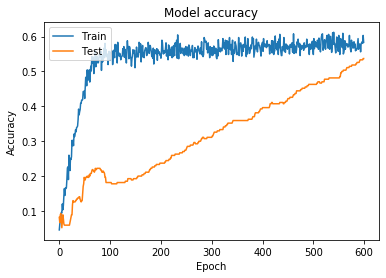

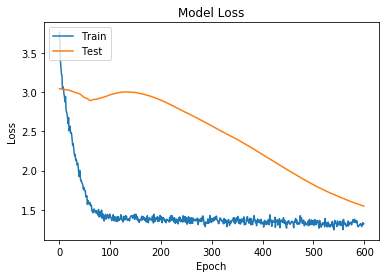

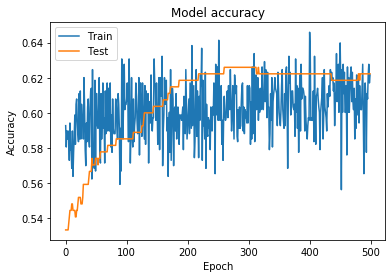

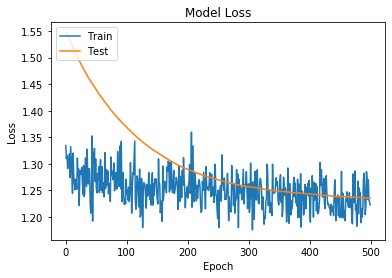

In [15]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Train and test on GT_split 3

In [20]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_3.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_3.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 265/265 [00:00<00:00, 333.05it/s]


In [21]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [22]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history1 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 663 samples, validate on 265 samples
Epoch 1/600
663/663 [==============================] - 5s 7ms/step - loss: 3.7925 - accuracy: 0.0422 - val_loss: 3.0452 - val_accuracy: 0.0340
Epoch 2/600
663/663 [==============================] - 0s 174us/step - loss: 3.5479 - accuracy: 0.0739 - val_loss: 3.0446 - val_accuracy: 0.0491
Epoch 3/600
663/663 [==============================] - 0s 152us/step - loss: 3.4327 - accuracy: 0.0633 - val_loss: 3.0432 - val_accuracy: 0.0604
Epoch 4/600
663/663 [==============================] - 0s 151us/step - loss: 3.3203 - accuracy: 0.1041 - val_loss: 3.0419 - val_accuracy: 0.0679
Epoch 5/600
663/663 [==============================] - 0s 153us/step - loss: 3.2685 - accuracy: 0.0965 - val_loss: 3.0409 - val_accuracy: 0.0717
Epoch 6/600
663/663 [==============================] - 0s 142us/step - loss: 3.1792 - accuracy: 0.1222 - val_loss: 3.0400 - val_accuracy: 0.0679
Epoch 7/600
663/663 [==============================] - 0s 144us/step - loss: 3.1698 - 

Epoch 57/600
663/663 [==============================] - 0s 137us/step - loss: 1.6963 - accuracy: 0.4857 - val_loss: 3.3388 - val_accuracy: 0.0792
Epoch 58/600
663/663 [==============================] - 0s 141us/step - loss: 1.6765 - accuracy: 0.4902 - val_loss: 3.3553 - val_accuracy: 0.0792
Epoch 59/600
663/663 [==============================] - 0s 145us/step - loss: 1.5824 - accuracy: 0.5158 - val_loss: 3.3747 - val_accuracy: 0.0792
Epoch 60/600
663/663 [==============================] - 0s 140us/step - loss: 1.6033 - accuracy: 0.4872 - val_loss: 3.3945 - val_accuracy: 0.0792
Epoch 61/600
663/663 [==============================] - 0s 140us/step - loss: 1.5955 - accuracy: 0.4842 - val_loss: 3.4176 - val_accuracy: 0.0792
Epoch 62/600
663/663 [==============================] - 0s 142us/step - loss: 1.5416 - accuracy: 0.5128 - val_loss: 3.4454 - val_accuracy: 0.0792
Epoch 63/600
663/663 [==============================] - 0s 140us/step - loss: 1.5446 - accuracy: 0.4962 - val_loss: 3.4740 -

663/663 [==============================] - 0s 130us/step - loss: 1.0914 - accuracy: 0.6486 - val_loss: 4.1019 - val_accuracy: 0.1170
Epoch 114/600
663/663 [==============================] - 0s 142us/step - loss: 1.0587 - accuracy: 0.6682 - val_loss: 4.1025 - val_accuracy: 0.1170
Epoch 115/600
663/663 [==============================] - 0s 133us/step - loss: 1.1131 - accuracy: 0.6350 - val_loss: 4.1067 - val_accuracy: 0.1170
Epoch 116/600
663/663 [==============================] - 0s 128us/step - loss: 1.0732 - accuracy: 0.6652 - val_loss: 4.1107 - val_accuracy: 0.1170
Epoch 117/600
663/663 [==============================] - 0s 130us/step - loss: 1.0763 - accuracy: 0.6440 - val_loss: 4.1164 - val_accuracy: 0.1170
Epoch 118/600
663/663 [==============================] - 0s 129us/step - loss: 1.0323 - accuracy: 0.6787 - val_loss: 4.1193 - val_accuracy: 0.1170
Epoch 119/600
663/663 [==============================] - 0s 131us/step - loss: 1.0370 - accuracy: 0.6742 - val_loss: 4.1197 - val_ac

Epoch 169/600
663/663 [==============================] - 0s 137us/step - loss: 0.9944 - accuracy: 0.6848 - val_loss: 3.9358 - val_accuracy: 0.1283
Epoch 170/600
663/663 [==============================] - 0s 132us/step - loss: 0.9821 - accuracy: 0.7029 - val_loss: 3.9288 - val_accuracy: 0.1283
Epoch 171/600
663/663 [==============================] - 0s 132us/step - loss: 1.0281 - accuracy: 0.6893 - val_loss: 3.9210 - val_accuracy: 0.1321
Epoch 172/600
663/663 [==============================] - 0s 140us/step - loss: 0.9783 - accuracy: 0.6953 - val_loss: 3.9131 - val_accuracy: 0.1358
Epoch 173/600
663/663 [==============================] - 0s 139us/step - loss: 0.9943 - accuracy: 0.6833 - val_loss: 3.9047 - val_accuracy: 0.1358
Epoch 174/600
663/663 [==============================] - 0s 131us/step - loss: 0.9905 - accuracy: 0.6953 - val_loss: 3.8971 - val_accuracy: 0.1358
Epoch 175/600
663/663 [==============================] - 0s 132us/step - loss: 0.9539 - accuracy: 0.6998 - val_loss: 3

Epoch 225/600
663/663 [==============================] - 0s 136us/step - loss: 0.9641 - accuracy: 0.7149 - val_loss: 3.4600 - val_accuracy: 0.1585
Epoch 226/600
663/663 [==============================] - 0s 132us/step - loss: 0.9990 - accuracy: 0.6757 - val_loss: 3.4511 - val_accuracy: 0.1585
Epoch 227/600
663/663 [==============================] - 0s 136us/step - loss: 1.0316 - accuracy: 0.6471 - val_loss: 3.4423 - val_accuracy: 0.1585
Epoch 228/600
663/663 [==============================] - 0s 144us/step - loss: 0.9952 - accuracy: 0.6938 - val_loss: 3.4338 - val_accuracy: 0.1623
Epoch 229/600
663/663 [==============================] - 0s 138us/step - loss: 0.9756 - accuracy: 0.6787 - val_loss: 3.4249 - val_accuracy: 0.1623
Epoch 230/600
663/663 [==============================] - 0s 136us/step - loss: 0.9848 - accuracy: 0.7179 - val_loss: 3.4158 - val_accuracy: 0.1623
Epoch 231/600
663/663 [==============================] - 0s 133us/step - loss: 1.0449 - accuracy: 0.6833 - val_loss: 3

Epoch 281/600
663/663 [==============================] - 0s 137us/step - loss: 0.9411 - accuracy: 0.6878 - val_loss: 2.9735 - val_accuracy: 0.2453
Epoch 282/600
663/663 [==============================] - 0s 137us/step - loss: 0.9920 - accuracy: 0.6983 - val_loss: 2.9657 - val_accuracy: 0.2415
Epoch 283/600
663/663 [==============================] - 0s 142us/step - loss: 0.9972 - accuracy: 0.6802 - val_loss: 2.9578 - val_accuracy: 0.2415
Epoch 284/600
663/663 [==============================] - 0s 131us/step - loss: 0.9646 - accuracy: 0.7014 - val_loss: 2.9498 - val_accuracy: 0.2415
Epoch 285/600
663/663 [==============================] - 0s 138us/step - loss: 1.0055 - accuracy: 0.6787 - val_loss: 2.9415 - val_accuracy: 0.2415
Epoch 286/600
663/663 [==============================] - 0s 139us/step - loss: 0.9631 - accuracy: 0.6908 - val_loss: 2.9340 - val_accuracy: 0.2453
Epoch 287/600
663/663 [==============================] - 0s 136us/step - loss: 0.9950 - accuracy: 0.6938 - val_loss: 2

Epoch 337/600
663/663 [==============================] - 0s 132us/step - loss: 0.9579 - accuracy: 0.7029 - val_loss: 2.5709 - val_accuracy: 0.2755
Epoch 338/600
663/663 [==============================] - 0s 134us/step - loss: 0.9389 - accuracy: 0.7315 - val_loss: 2.5649 - val_accuracy: 0.2755
Epoch 339/600
663/663 [==============================] - 0s 137us/step - loss: 0.9578 - accuracy: 0.6833 - val_loss: 2.5584 - val_accuracy: 0.2830
Epoch 340/600
663/663 [==============================] - 0s 136us/step - loss: 0.9859 - accuracy: 0.7029 - val_loss: 2.5521 - val_accuracy: 0.2830
Epoch 341/600
663/663 [==============================] - 0s 136us/step - loss: 0.9944 - accuracy: 0.7029 - val_loss: 2.5452 - val_accuracy: 0.2830
Epoch 342/600
663/663 [==============================] - 0s 137us/step - loss: 0.9798 - accuracy: 0.6848 - val_loss: 2.5389 - val_accuracy: 0.2830
Epoch 343/600
663/663 [==============================] - 0s 129us/step - loss: 1.0179 - accuracy: 0.6757 - val_loss: 2

Epoch 393/600
663/663 [==============================] - 0s 129us/step - loss: 1.0000 - accuracy: 0.6802 - val_loss: 2.2327 - val_accuracy: 0.3283
Epoch 394/600
663/663 [==============================] - 0s 134us/step - loss: 0.9269 - accuracy: 0.7195 - val_loss: 2.2273 - val_accuracy: 0.3358
Epoch 395/600
663/663 [==============================] - 0s 127us/step - loss: 0.9440 - accuracy: 0.7134 - val_loss: 2.2217 - val_accuracy: 0.3321
Epoch 396/600
663/663 [==============================] - 0s 128us/step - loss: 0.9859 - accuracy: 0.6923 - val_loss: 2.2162 - val_accuracy: 0.3358
Epoch 397/600
663/663 [==============================] - 0s 127us/step - loss: 0.9679 - accuracy: 0.6968 - val_loss: 2.2113 - val_accuracy: 0.3358
Epoch 398/600
663/663 [==============================] - 0s 131us/step - loss: 0.9919 - accuracy: 0.6667 - val_loss: 2.2061 - val_accuracy: 0.3396
Epoch 399/600
663/663 [==============================] - 0s 134us/step - loss: 0.9921 - accuracy: 0.6938 - val_loss: 2

Epoch 449/600
663/663 [==============================] - 0s 133us/step - loss: 0.9516 - accuracy: 0.7089 - val_loss: 1.9630 - val_accuracy: 0.4189
Epoch 450/600
663/663 [==============================] - 0s 138us/step - loss: 0.9646 - accuracy: 0.6968 - val_loss: 1.9592 - val_accuracy: 0.4189
Epoch 451/600
663/663 [==============================] - 0s 130us/step - loss: 0.9055 - accuracy: 0.7195 - val_loss: 1.9550 - val_accuracy: 0.4226
Epoch 452/600
663/663 [==============================] - 0s 133us/step - loss: 0.9545 - accuracy: 0.7210 - val_loss: 1.9508 - val_accuracy: 0.4226
Epoch 453/600
663/663 [==============================] - 0s 128us/step - loss: 0.9629 - accuracy: 0.6923 - val_loss: 1.9467 - val_accuracy: 0.4264
Epoch 454/600
663/663 [==============================] - 0s 134us/step - loss: 0.9619 - accuracy: 0.6757 - val_loss: 1.9427 - val_accuracy: 0.4302
Epoch 455/600
663/663 [==============================] - 0s 136us/step - loss: 0.9568 - accuracy: 0.7149 - val_loss: 1

Epoch 505/600
663/663 [==============================] - 0s 133us/step - loss: 0.9284 - accuracy: 0.7330 - val_loss: 1.7627 - val_accuracy: 0.4830
Epoch 506/600
663/663 [==============================] - 0s 131us/step - loss: 0.9722 - accuracy: 0.6983 - val_loss: 1.7597 - val_accuracy: 0.4830
Epoch 507/600
663/663 [==============================] - 0s 129us/step - loss: 0.9226 - accuracy: 0.7210 - val_loss: 1.7568 - val_accuracy: 0.4830
Epoch 508/600
663/663 [==============================] - 0s 131us/step - loss: 0.9421 - accuracy: 0.7014 - val_loss: 1.7539 - val_accuracy: 0.4830
Epoch 509/600
663/663 [==============================] - 0s 134us/step - loss: 0.9374 - accuracy: 0.7240 - val_loss: 1.7511 - val_accuracy: 0.4830
Epoch 510/600
663/663 [==============================] - 0s 133us/step - loss: 0.9267 - accuracy: 0.7149 - val_loss: 1.7482 - val_accuracy: 0.4830
Epoch 511/600
663/663 [==============================] - 0s 135us/step - loss: 0.9679 - accuracy: 0.6968 - val_loss: 1

Epoch 561/600
663/663 [==============================] - 0s 127us/step - loss: 0.9529 - accuracy: 0.7210 - val_loss: 1.6196 - val_accuracy: 0.5245
Epoch 562/600
663/663 [==============================] - 0s 130us/step - loss: 0.9585 - accuracy: 0.6923 - val_loss: 1.6175 - val_accuracy: 0.5245
Epoch 563/600
663/663 [==============================] - 0s 131us/step - loss: 0.9416 - accuracy: 0.6983 - val_loss: 1.6153 - val_accuracy: 0.5245
Epoch 564/600
663/663 [==============================] - 0s 129us/step - loss: 0.9102 - accuracy: 0.7300 - val_loss: 1.6132 - val_accuracy: 0.5245
Epoch 565/600
663/663 [==============================] - 0s 133us/step - loss: 0.9694 - accuracy: 0.6878 - val_loss: 1.6110 - val_accuracy: 0.5208
Epoch 566/600
663/663 [==============================] - 0s 133us/step - loss: 0.9326 - accuracy: 0.7270 - val_loss: 1.6090 - val_accuracy: 0.5208
Epoch 567/600
663/663 [==============================] - 0s 128us/step - loss: 0.9524 - accuracy: 0.7014 - val_loss: 1

Epoch 17/500
663/663 [==============================] - 0s 139us/step - loss: 0.8384 - accuracy: 0.7541 - val_loss: 1.5777 - val_accuracy: 0.5283
Epoch 18/500
663/663 [==============================] - 0s 135us/step - loss: 0.8330 - accuracy: 0.7421 - val_loss: 1.5716 - val_accuracy: 0.5321
Epoch 19/500
663/663 [==============================] - 0s 127us/step - loss: 0.8502 - accuracy: 0.7496 - val_loss: 1.5624 - val_accuracy: 0.5358
Epoch 20/500
663/663 [==============================] - 0s 145us/step - loss: 0.8496 - accuracy: 0.7406 - val_loss: 1.5572 - val_accuracy: 0.5396
Epoch 21/500
663/663 [==============================] - 0s 129us/step - loss: 0.7790 - accuracy: 0.7602 - val_loss: 1.5529 - val_accuracy: 0.5509
Epoch 22/500
663/663 [==============================] - 0s 150us/step - loss: 0.8255 - accuracy: 0.7436 - val_loss: 1.5503 - val_accuracy: 0.5472
Epoch 23/500
663/663 [==============================] - 0s 141us/step - loss: 0.8211 - accuracy: 0.7526 - val_loss: 1.5480 -

Epoch 74/500
663/663 [==============================] - 0s 142us/step - loss: 0.6484 - accuracy: 0.7964 - val_loss: 1.4369 - val_accuracy: 0.5623
Epoch 75/500
663/663 [==============================] - 0s 141us/step - loss: 0.6962 - accuracy: 0.7979 - val_loss: 1.4357 - val_accuracy: 0.5623
Epoch 76/500
663/663 [==============================] - 0s 143us/step - loss: 0.6863 - accuracy: 0.8009 - val_loss: 1.4344 - val_accuracy: 0.5623
Epoch 77/500
663/663 [==============================] - 0s 142us/step - loss: 0.7429 - accuracy: 0.7677 - val_loss: 1.4329 - val_accuracy: 0.5623
Epoch 78/500
663/663 [==============================] - 0s 144us/step - loss: 0.7602 - accuracy: 0.7722 - val_loss: 1.4315 - val_accuracy: 0.5623
Epoch 79/500
663/663 [==============================] - 0s 143us/step - loss: 0.7216 - accuracy: 0.7828 - val_loss: 1.4301 - val_accuracy: 0.5623
Epoch 80/500
663/663 [==============================] - 0s 142us/step - loss: 0.7790 - accuracy: 0.7632 - val_loss: 1.4287 -

Epoch 130/500
663/663 [==============================] - 0s 134us/step - loss: 0.7309 - accuracy: 0.7813 - val_loss: 1.3802 - val_accuracy: 0.5660
Epoch 131/500
663/663 [==============================] - 0s 133us/step - loss: 0.7082 - accuracy: 0.7979 - val_loss: 1.3794 - val_accuracy: 0.5698
Epoch 132/500
663/663 [==============================] - 0s 135us/step - loss: 0.7288 - accuracy: 0.7647 - val_loss: 1.3787 - val_accuracy: 0.5698
Epoch 133/500
663/663 [==============================] - 0s 133us/step - loss: 0.6753 - accuracy: 0.8220 - val_loss: 1.3780 - val_accuracy: 0.5698
Epoch 134/500
663/663 [==============================] - 0s 135us/step - loss: 0.7181 - accuracy: 0.7572 - val_loss: 1.3773 - val_accuracy: 0.5698
Epoch 135/500
663/663 [==============================] - 0s 137us/step - loss: 0.7191 - accuracy: 0.7813 - val_loss: 1.3766 - val_accuracy: 0.5698
Epoch 136/500
663/663 [==============================] - 0s 141us/step - loss: 0.7506 - accuracy: 0.7873 - val_loss: 1

Epoch 186/500
663/663 [==============================] - 0s 135us/step - loss: 0.6949 - accuracy: 0.7964 - val_loss: 1.3504 - val_accuracy: 0.5887
Epoch 187/500
663/663 [==============================] - 0s 134us/step - loss: 0.7089 - accuracy: 0.7903 - val_loss: 1.3500 - val_accuracy: 0.5849
Epoch 188/500
663/663 [==============================] - 0s 136us/step - loss: 0.7122 - accuracy: 0.7873 - val_loss: 1.3496 - val_accuracy: 0.5887
Epoch 189/500
663/663 [==============================] - 0s 134us/step - loss: 0.7062 - accuracy: 0.7722 - val_loss: 1.3491 - val_accuracy: 0.5887
Epoch 190/500
663/663 [==============================] - 0s 133us/step - loss: 0.7246 - accuracy: 0.7692 - val_loss: 1.3488 - val_accuracy: 0.5887
Epoch 191/500
663/663 [==============================] - 0s 132us/step - loss: 0.7331 - accuracy: 0.7632 - val_loss: 1.3484 - val_accuracy: 0.5849
Epoch 192/500
663/663 [==============================] - 0s 133us/step - loss: 0.7327 - accuracy: 0.7813 - val_loss: 1

Epoch 242/500
663/663 [==============================] - 0s 131us/step - loss: 0.7063 - accuracy: 0.7934 - val_loss: 1.3356 - val_accuracy: 0.5887
Epoch 243/500
663/663 [==============================] - 0s 133us/step - loss: 0.6556 - accuracy: 0.8115 - val_loss: 1.3354 - val_accuracy: 0.5887
Epoch 244/500
663/663 [==============================] - 0s 135us/step - loss: 0.6935 - accuracy: 0.7949 - val_loss: 1.3351 - val_accuracy: 0.5887
Epoch 245/500
663/663 [==============================] - 0s 128us/step - loss: 0.6727 - accuracy: 0.7888 - val_loss: 1.3350 - val_accuracy: 0.5887
Epoch 246/500
663/663 [==============================] - 0s 134us/step - loss: 0.7898 - accuracy: 0.7768 - val_loss: 1.3348 - val_accuracy: 0.5887
Epoch 247/500
663/663 [==============================] - 0s 131us/step - loss: 0.7199 - accuracy: 0.7738 - val_loss: 1.3345 - val_accuracy: 0.5887
Epoch 248/500
663/663 [==============================] - 0s 133us/step - loss: 0.7113 - accuracy: 0.7843 - val_loss: 1

Epoch 298/500
663/663 [==============================] - 0s 140us/step - loss: 0.6935 - accuracy: 0.7964 - val_loss: 1.3270 - val_accuracy: 0.5962
Epoch 299/500
663/663 [==============================] - 0s 142us/step - loss: 0.6807 - accuracy: 0.7873 - val_loss: 1.3269 - val_accuracy: 0.5962
Epoch 300/500
663/663 [==============================] - 0s 142us/step - loss: 0.6985 - accuracy: 0.7692 - val_loss: 1.3269 - val_accuracy: 0.5962
Epoch 301/500
663/663 [==============================] - 0s 139us/step - loss: 0.6941 - accuracy: 0.7798 - val_loss: 1.3268 - val_accuracy: 0.5962
Epoch 302/500
663/663 [==============================] - 0s 140us/step - loss: 0.7296 - accuracy: 0.7692 - val_loss: 1.3267 - val_accuracy: 0.5962
Epoch 303/500
663/663 [==============================] - 0s 141us/step - loss: 0.7014 - accuracy: 0.7843 - val_loss: 1.3266 - val_accuracy: 0.5962
Epoch 304/500
663/663 [==============================] - 0s 130us/step - loss: 0.6955 - accuracy: 0.8039 - val_loss: 1

Epoch 354/500
663/663 [==============================] - 0s 132us/step - loss: 0.7191 - accuracy: 0.7828 - val_loss: 1.3220 - val_accuracy: 0.6038
Epoch 355/500
663/663 [==============================] - 0s 129us/step - loss: 0.6927 - accuracy: 0.8024 - val_loss: 1.3220 - val_accuracy: 0.6038
Epoch 356/500
663/663 [==============================] - 0s 136us/step - loss: 0.7036 - accuracy: 0.7949 - val_loss: 1.3218 - val_accuracy: 0.6038
Epoch 357/500
663/663 [==============================] - 0s 136us/step - loss: 0.7108 - accuracy: 0.7919 - val_loss: 1.3218 - val_accuracy: 0.6038
Epoch 358/500
663/663 [==============================] - 0s 133us/step - loss: 0.7114 - accuracy: 0.7768 - val_loss: 1.3217 - val_accuracy: 0.6038
Epoch 359/500
663/663 [==============================] - 0s 134us/step - loss: 0.6673 - accuracy: 0.7903 - val_loss: 1.3216 - val_accuracy: 0.6038
Epoch 360/500
663/663 [==============================] - 0s 135us/step - loss: 0.6415 - accuracy: 0.8100 - val_loss: 1

Epoch 410/500
663/663 [==============================] - 0s 133us/step - loss: 0.7538 - accuracy: 0.7662 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 411/500
663/663 [==============================] - 0s 135us/step - loss: 0.6544 - accuracy: 0.8009 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 412/500
663/663 [==============================] - 0s 139us/step - loss: 0.7229 - accuracy: 0.7677 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 413/500
663/663 [==============================] - 0s 131us/step - loss: 0.7186 - accuracy: 0.7738 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 414/500
663/663 [==============================] - 0s 136us/step - loss: 0.7197 - accuracy: 0.7677 - val_loss: 1.3187 - val_accuracy: 0.6038
Epoch 415/500
663/663 [==============================] - 0s 133us/step - loss: 0.6464 - accuracy: 0.8130 - val_loss: 1.3188 - val_accuracy: 0.6038
Epoch 416/500
663/663 [==============================] - 0s 132us/step - loss: 0.6820 - accuracy: 0.7919 - val_loss: 1

Epoch 466/500
663/663 [==============================] - 0s 136us/step - loss: 0.7016 - accuracy: 0.7828 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 467/500
663/663 [==============================] - 0s 134us/step - loss: 0.6956 - accuracy: 0.7949 - val_loss: 1.3171 - val_accuracy: 0.6038
Epoch 468/500
663/663 [==============================] - 0s 132us/step - loss: 0.7127 - accuracy: 0.7783 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 469/500
663/663 [==============================] - 0s 135us/step - loss: 0.7664 - accuracy: 0.7632 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 470/500
663/663 [==============================] - 0s 133us/step - loss: 0.6624 - accuracy: 0.7949 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 471/500
663/663 [==============================] - 0s 133us/step - loss: 0.6534 - accuracy: 0.7858 - val_loss: 1.3170 - val_accuracy: 0.6038
Epoch 472/500
663/663 [==============================] - 0s 134us/step - loss: 0.6812 - accuracy: 0.7873 - val_loss: 1

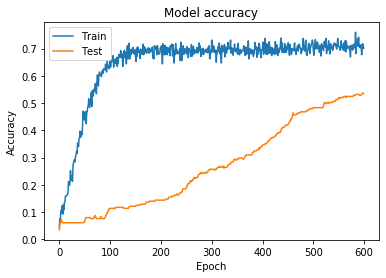

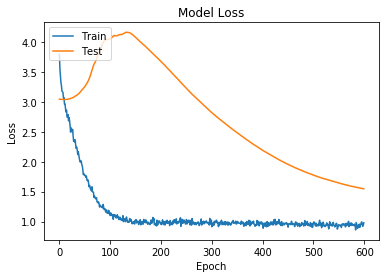

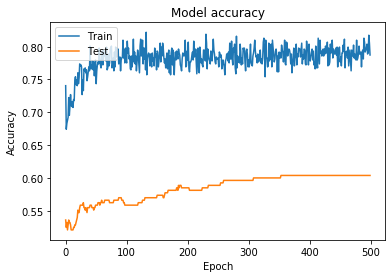

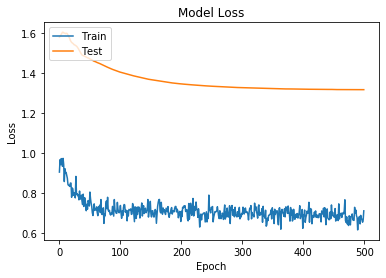

In [23]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

## Calculate average 

In [ ]:
(0.63+0.66+0.68)/3